
## Analytic Solutions Convergence Tests

This notebook runs series of simulations across different resolutions to extract error convergence information. Analytic Stokes flow solutions are used as a basis for error estimation. 


In [6]:
from collections import OrderedDict as OD
regress_solns = [
#   ("name", {soln_params},         {solver_tolerances},           graph_result )
    ("A",    OD(),                  {"itol":1.e-6, "otol":1.e-6},  False ),
    ("B",    OD(),                  {"itol":1.e-5, "otol":1.e-5},  False ),
    ("C",    OD(),                  {"itol":1.e-5, "otol":1.e-5},  False ),
    ("Cx",   OD(),                  {"itol":1.e-9, "otol":1.e-9},  True  ),
    ("DA",   OD(),                  {"itol":1.e-7, "otol":1.e-7},  True  ),
    ("H",    OD([("nmodes",240),]), {"itol":1.e-6, "otol":1.e-6},  True  ),
    ("Kx",   OD(),                  {"itol":1.e-4, "otol":1.e-4},  False ),
    ("Kz",   OD(),                  {"itol":1.e-4, "otol":1.e-4},  False ),
    ("M",    OD(),                  {"itol":1.e-6, "otol":1.e-6},  False ),
    ("NL",   OD(),                  {"itol":1.e-7, "otol":1.e-7},  True  ),
    ("DB2d", OD(),                  {"itol":1.e-6, "otol":1.e-6},  False ),
    ("DB3d", OD(),                  {"itol":1.e-8, "otol":1.e-8},  False ),    
]

rerun_all   = False
run_missing = False
use_storage = True   # if False, previous results are ignored
do_analysis = True
graph_all   = False
two_d_only  = True

regress_res = [8,16,32,64]
orders      = [1,2]

if len(regress_res)<2:
    raise RuntimeError("At least 2 resolutions required for regression analysis.")

In [7]:
import underworld as uw
# uw.timing.start()
import underworld.glucifer as glucifer
from underworld import function as fn
import math
import numpy as np
import collections

uw.matplotlib_inline()

In [8]:
# Find all available solutions. 
# Use ordered dict to preserve alphabetical ordering
solns_avail = collections.OrderedDict()
for soln_name in dir(fn.analytic):
    if soln_name[0] == "_": continue  # if private member, ignore
    # get soln class
    soln = getattr(fn.analytic,soln_name)
    # check if actually soln
    if issubclass(soln, fn.analytic._SolBase):
        solns_avail[soln_name] = soln

In [9]:
solns = collections.OrderedDict()
for sol in regress_solns:
    solname = "Sol"+sol[0]
    solns[solname] = solns_avail[solname.split(',')[0]](**sol[1])
    solns[solname].parameters = sol[1]   # record this for the table later
    solns[solname].tolerances = sol[2]   # record required tolerances as well
    solns[solname].graph      = True if graph_all else sol[3]   # record if should add to graph

In [5]:
# Create the tools we need

def get_numerical( soln, res=32, order=1, itol=1.e-6, otol=1.e-6 ):
    '''
    Creates the numerical system corresponding to the provided analytic system.
    
    Parameters
    ----------
    soln : uw.function.analytic._SolBase
        The analytic system
    res : int
        System resolution. Same resolution is used for each axis.
    order : int
        System numerical order. 
    itol : float
        Inner solve tolerance.
    otol : float
        Outer solve tolerance.

        
    '''
    if order == 1:
        els = "Q1/dQ0"
    elif order == 2:
        els = "Q2/dPc1"
    else:
        raise ValueError("Provided system order should be 1 or 2.")

    dim = soln.dim
    mesh  = uw.mesh.FeMesh_Cartesian(elementType=els, elementRes=(res,)*dim,minCoord=(0.,)*dim,maxCoord=(1.,)*dim)
    vel   = uw.mesh.MeshVariable(mesh,dim)
    press = uw.mesh.MeshVariable(mesh.subMesh, 1)
    vel.data[:]   = (0.,)*dim
    press.data[:] = 0.

    bcs = soln.get_bcs(vel)
    visc = soln.fn_viscosity
    if soln.nonlinear==True:
        visc = soln.get_viscosity_nl(vel,press)
    stokes = uw.systems.Stokes(vel, press, fn_viscosity=visc, fn_bodyforce=soln.fn_bodyforce, conditions=[bcs,])
    solver = uw.systems.Solver(stokes)
    if uw.mpi.size==1:
        solver.set_inner_method("lu")
    solver.set_inner_rtol(itol)
    solver.set_outer_rtol(otol)
    
    # if nonlinear, lets first grab a const visc approx soln
    if soln.nonlinear==True:
        stokes.fn_viscosity = 1.
        solver.solve()
        stokes.fn_viscosity = visc

    return mesh, vel, press, solver

def normalise_press(press):
    intSwarm = uw.swarm.GaussIntegrationSwarm(mesh,3)  # use 3 point gauss swarms for efficiency
    av_press = uw.utils.Integral( press, mesh, integrationSwarm=intSwarm, integrationType=None).evaluate()[0]
    
    return press - av_press

def rms_error(numeric, analytic, mesh):
    '''
    Calculates the rms error.
    
    Returns
    -------
    abs, abs_scaled: float
        The absolute and scaled absolute errors.
    '''

    delta     = analytic - numeric
    delta_dot = fn.math.dot(delta,delta)

    analytic_dot = fn.math.dot(analytic,analytic)
    
    # l2 norms
    intSwarm = uw.swarm.GaussIntegrationSwarm(mesh,3)  # use 3 point gauss swarms for efficiency
    rms_err_abs = np.sqrt(uw.utils.Integral(    delta_dot, mesh, integrationSwarm=intSwarm, integrationType=None ).evaluate()[0])
    rms_sol_ana = np.sqrt(uw.utils.Integral( analytic_dot, mesh, integrationSwarm=intSwarm, integrationType=None ).evaluate()[0])
    rms_err_sca = rms_err_abs / rms_sol_ana
        
    return rms_err_abs, rms_err_sca

### Now perform convergence rate tests 

In [6]:
velocity_key = "Velocity"
pressure_key = "Pressure"

resolutions = regress_res
dx = np.reciprocal(resolutions,dtype='double')

In [7]:
# with open("conv_test_results.pickle",'rb') as f:
#     import pickle
#     soln_results = pickle.load(f)
# with open("conv_test_results.pickle_db3d",'rb') as f:
#     import pickle
#     soln_results_db3d = pickle.load(f)
# ord = 2
# field = "Velocity"
# soln_results[("SolDB3d",ord,field)] = soln_results_db3d[("SolDB3d",ord,field)]
# soln_results[("SolDB3d",ord,field)].tolerances
# with open("conv_test_results.pickle",'wb') as f:
#     import pickle
#     f.write(pickle.dumps(soln_results))

In [8]:
try:
    # try and load existing results
    with open("conv_test_results.pickle",'rb') as f:
        import pickle
        soln_results = pickle.load(f)
except:
    # if failed, it's most prob because the file doesn't 
    # exist. in this case, create empty dict.
    soln_results = collections.OrderedDict()

if use_storage==False:
    soln_results = collections.OrderedDict()

if run_missing:
    for soln_name in solns.keys():
        solnguy = solns[soln_name]
        if (solnguy.dim == 3) and two_d_only:
            continue
        for order in orders:
            if (soln_name,order,velocity_key) in soln_results:
                err_pre = soln_results[ (soln_name,order,pressure_key) ]
                err_vel = soln_results[ (soln_name,order,velocity_key) ]
                # if not identical to existing, rerun all
                if (err_vel.parameters!=solnguy.parameters) or (err_vel.tolerances!=solnguy.tolerances):
#                     raise RuntimeError("{} {} {}".format(soln_name,err_vel.parameters,err_vel.tolerances))
                    err_pre = collections.OrderedDict()
                    err_vel = collections.OrderedDict()

            else:
                err_pre = collections.OrderedDict()
                err_vel = collections.OrderedDict()


            
            for res in resolutions:
                # do not rerun existing results
                if res in err_vel and not rerun_all:
                    continue
                mesh, vel, press, solver = get_numerical( solnguy, res, order=order, **solnguy.tolerances )

                if uw.mpi.rank==0: print("Performing simulations for solution: {} {} {}".format(soln_name, order, res), flush=True)

                if solnguy.nonlinear!=True:
                    solver.solve()
                else:
                    solver.solve(nonLinearIterate=True,nonLinearTolerance=1.e-7)

                pressn = normalise_press(press)
                pressa = normalise_press(solnguy.fn_pressure)

                err_vel[res] = rms_error(    vel, solnguy.fn_velocity, mesh )
                err_pre[res] = rms_error( pressn,              pressa, mesh )

                # lets store these for future comparison
                err_vel.parameters = solnguy.parameters
                err_vel.tolerances = solnguy.tolerances

                soln_results[(soln_name,order,velocity_key)] = err_vel
                soln_results[(soln_name,order,pressure_key)] = err_pre
                
                # record full state back to pickled dict
                if uw.mpi.rank==0 and use_storage:
                    with open("conv_test_results.pickle",'wb') as f:
                        import pickle
                        f.write(pickle.dumps(soln_results))

Performing analysis.


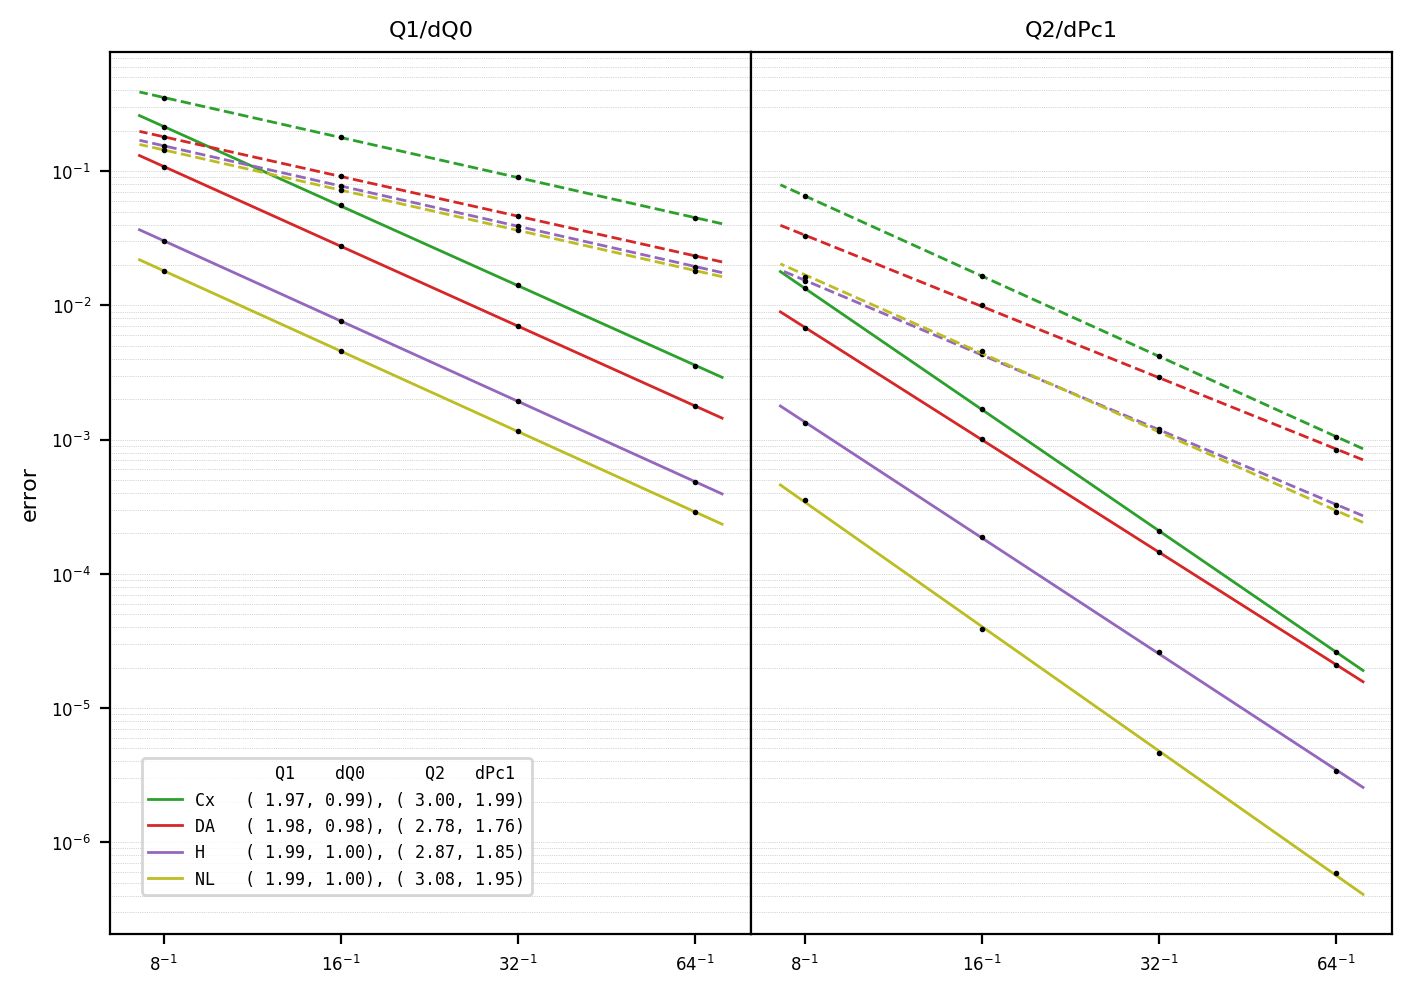

In [9]:
if (uw.mpi.rank==0) and do_analysis:
    print("Performing analysis.", flush=True)

    errtype = 1  # {0:"absolute", 1:"scaled absolute"}
    
    fitfn = lambda x,a,b: a+b*x
    def get_linear_fit(x,y):
        '''
        Returns best fit (a,b) for $ln(y)=a+b*ln(x)$ for provided
        set of points (x,y).
        '''
        import scipy.optimize
        return scipy.optimize.curve_fit(fitfn,  np.log(x),  np.log(y))

    def get_fit_line(dx, fit):
        '''
        Evaluates fit across a set of points.
        '''
        dxmin = 0.9*dx.min()
        dxmax = 1.1*dx.max()
        xpts = np.linspace(dxmin,dxmax,20)
        ypts = np.exp(fitfn(np.log(xpts),*fit))
        return xpts, ypts

    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
    plt.subplots_adjust(wspace=.0)
    
    # create some consistent colours & linestyles
    from matplotlib.pyplot import cm
    colours = cm.tab10(np.linspace(0,1,len(solns.keys())))
    scheme = {}
    for it,sol in enumerate(solns.keys()):
        scheme[(sol,pressure_key)] = (colours[it],'--')
        scheme[(sol,velocity_key)] = (colours[it],'-')


    def create_ax(pos, title=None, other_ax=None):
        ax = plt.subplot(1,2,pos,xscale='log', yscale='log', sharey=other_ax)
        ax.set_title(title,fontsize=8)
        ax.invert_xaxis()
        ax.xaxis.set_ticks(dx)
        ax.xaxis.set_ticklabels(["$ {{ {} }}^{{-1}}$".format(x) for x in resolutions])
        ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
        ax.tick_params(axis='both', which='major', labelsize=8)
#         ax.set_xlabel("dx", fontsize=8)
        if not other_ax:
            ax.set_ylabel("error", fontsize=8)

        # disable minor ticks marks on axis
        for tic in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
            tic.label.set_fontsize(6)
        # disable tick marks on rhs of other axis
        if other_ax:
            for tic in ax.yaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
        return ax
    
    axes = {}
    axes[1] = create_ax(1, title="Q1/dQ0")
    axes[2] = create_ax(2, title="Q2/dPc1", other_ax=axes[1] )
    
    # get fit results now so we can set plot labels
    fits = {}
    errs = {}
    for key, err in soln_results.items():
        soln_name = key[0]
        if (soln_name not in solns): #or (solns[soln_name].graph==False):
            continue

        fits[key], errs[key] = get_linear_fit(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()] )

    # keep set of lines for legend
    lines = collections.OrderedDict()
    for key, err in sorted(soln_results.items(), key=lambda x: x[0][0]):
        soln_name = key[0]
        if (soln_name not in solns) or (solns[soln_name].graph==False):
            continue
        order     = key[1]
        velpres   = key[2]
        ax        = axes[order]
        fit       = fits[key]
        fitdata   = get_fit_line(np.reciprocal(list(err.keys()),dtype='double'),fit)    

        expected_order = order if (key[2]==pressure_key) else order+1
        if not np.isclose(fit[1],expected_order,rtol=1.5e-1):
            print("Rejecting {} fit = {}, expected = {}.".format(soln_name,fit[1],expected_order))

        col,ls = scheme[(soln_name,velpres)]
        line = ax.plot(*fitdata, linewidth=1., color=col, linestyle=ls)
        if velpres == velocity_key:
            lines[soln_name] = line
        
        ax.plot(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()], 'o', markersize=1., color='black')

    lbls = []
    lns = []
    for soln_name in lines.keys():
        vel_1   = fits[(soln_name,1,velocity_key)][1]
        pre_1   = fits[(soln_name,1,pressure_key)][1]
        vel_2   = fits[(soln_name,2,velocity_key)][1]
        pre_2   = fits[(soln_name,2,pressure_key)][1]
        lbls.append("{} ({: .2f},{: .2f}), ({: .2f},{: .2f})".format(soln_name[3:].ljust(4), vel_1, pre_1, vel_2, pre_2))
        lns.append(lines[soln_name][0])
    
    leg = fig.legend( lns, lbls, loc = (0.1, 0.1), prop={'family': 'monospace', 'size':6})
    leg.set_title("Q1    dQ0      Q2   dPc1 ", 
                  {'family': 'monospace', 'size':6 })
    leg._legend_box.align = "right"
#     fig.savefig("conv.png")

In [10]:
### errsall = []
# for key,err in errs.items():
#     errsall.append(np.sqrt(np.diag(err))[1])
# np.max(errsall)

In [11]:
# get viscosity range for all solns
viscdiff = {}
for soln_name in solns.keys():
    soln = solns[soln_name]

    dim  = soln.dim
    res = int(np.max(np.array(regress_res)))
    mesh = uw.mesh.FeMesh_Cartesian(elementType="q1/dq0", elementRes=(res,)*dim,minCoord=(0.,)*dim,maxCoord=(1.,)*dim)

    # grab min/max visc now as well
    fnminmaxvisc = fn.view.min_max(soln.fn_viscosity)
    fnminmaxvisc.reset()
    fnminmaxvisc.evaluate(mesh)
    
    viscdiff[soln_name] = fnminmaxvisc.max_global() - fnminmaxvisc.min_global()

viscstrings = {}
for key, vd in viscdiff.items():
    import math
    if vd < 0.001:
        viscstrings[key] = "0"
    else:
        viscstrings[key] = "\\num{" + "10^{}".format(round(math.log10(vd))) +"}"

In [12]:
print(viscstrings)

{'SolH': '0', 'SolCx': '\\num{10^8}', 'SolDA': '\\num{10^1}', 'SolDB3d': '\\num{10^0}', 'SolKz': '\\num{10^2}', 'SolM': '\\num{10^0}', 'SolC': '0', 'SolDB2d': '0', 'SolA': '0', 'SolKx': '\\num{10^2}', 'SolB': '0', 'SolNL': '\\num{10^0}'}


In [11]:
latex = True
if uw.mpi.rank==0 and latex:
    def latex_from_dict(dictguy):
        if len(dictguy)==0:
            return ""
        stringguy1 = "("
        stringguy2 = "("
        for key,val in dictguy.items():
            stringguy1+= key + ","
            if val < 1e2:
                stringguy2+="\\num{" +  str(val) + "},"
            else:
                stringguy2+="\\num{" +  "{0:.0e}".format(val) + "},"
        stringguy1 = stringguy1[:-1] + ")"  # remove last comma and add parentheses
        stringguy2 = stringguy2[:-1] + ")"
        stringguy1 = stringguy1.replace("eta",   "\eta")
        stringguy1 = stringguy1.replace("sigma", "\sigma")
        return stringguy1 + "=" + stringguy2
    def latex_from_sci(scinum):
        if latex:
            return "\\num{" + "{0:.0e}".format(scinum)[1:] + "}"
        else:
            return str(scinum)
    rows = []
    header = []
    im_options="height=1.5cm,keepaspectratio"
    for solname,solval  in solns.items():
        row = []
        header.append("\\text{Model}")
        row.append("\\text{"+solname[3:]+"}")              
#         header.append("\mathbf{F}")
#         row.append(solval.eqn_bodyforce) 
#         header.append("\eta")
#         row.append(solval.eqn_viscosity) 
#         header.append("\\text{Parameters}")
#         row.append(latex_from_dict(solval.parameters))
        header.append("\\eta")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_viscosity.png"))
        header.append("\\mid \mathbf{F} \\mid")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_bodyforce.png"))
        header.append("\\mid \mathbf{V} \\mid")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_velocity.png"))
        header.append("\\mid \mathbf{V}-\mathbf{V}^h \\mid")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_velocity_error.png"))
        header.append("P")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_pressure.png"))
        header.append("\\mid P-P^h \\mid")
        row.append("\includegraphics[{0}]{{images/{1}}}".format(im_options,solname+"_pressure_error.png"))
#         header.append("\\text{Q1}")
#         row.append("{:.2f}".format(fits[(solname,1,velocity_key)][1]))
#         header.append("\\text{dQ0}")
#         row.append("{:.2f}".format(fits[(solname,1,pressure_key)][1]))
#         header.append("\\text{Q2}")
#         row.append("{:.2f}".format(fits[(solname,2,velocity_key)][1]))
#         header.append("\\text{dPc1}")
#         row.append("{:.2f}".format(fits[(solname,2,pressure_key)][1]))
#         header.append("\mathrm{tol}_i")
#         row.append(latex_from_sci(solval.tolerances['itol']))
#         header.append("\mathrm{tol}_o")
#         row.append(latex_from_sci(solval.tolerances['otol']))
#         header.append("\sim \Delta \eta")
#         row.append(viscstrings[solname])

        rows.append(row)

    import tabulate
    tabulate.LATEX_ESCAPE_RULES={}
    print(tabulate.tabulate(rows, tablefmt='latex_raw',floatfmt=".2f",headers=header).replace('tabular','tabu'))

\begin{tabu}{lllllll}
\hline
 \text{Model}   & \eta                                                                         & \mid \mathbf{F} \mid                                                         & \mid \mathbf{V} \mid                                                        & \mid \mathbf{V}-\mathbf{V}^h \mid                                                 & P                                                                           & \mid P-P^h \mid                                                                   \\
\hline
 \text{A}       & \includegraphics[height=1.5cm,keepaspectratio]{images/SolA_viscosity.png}    & \includegraphics[height=1.5cm,keepaspectratio]{images/SolA_bodyforce.png}    & \includegraphics[height=1.5cm,keepaspectratio]{images/SolA_velocity.png}    & \includegraphics[height=1.5cm,keepaspectratio]{images/SolA_velocity_error.png}    & \includegraphics[height=1.5cm,keepaspectratio]{images/SolA_pressure.png}    & \includegraphics[height=1.5cm,keepaspectratio]{